# **NLP Based Sentiment Analysis on Product Reviews (IMDb)**
## Developed By: **Md. Shoaib Ahmed**

## Install necessary libraries

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

In [ ]:
!pip install datasets
!pip install tensorflow
!pip install transformers

## Importing necessary libraries

In [ ]:
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import re

In [ ]:
import torch

In [ ]:
import nltk
nltk.download('punkt_tab')  # Download the punkt_tab tokenizer resource

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Load IMDB dataset using Hugging Face Datasets

In [ ]:
imdb = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Show dataset structure

In [ ]:
print(imdb)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


## EDA (Exploratory Data Analysis)

### 1. Dataset Overview

{'text': 'i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in  i also heard that at first it was seized by us customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myselfthe plot is centered around a young swedish drama student named lena who wants to learn everything she can about life in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married menwhat kills me about i am curiousyellow is that  years ago this was considered pornographic really the sex and nudity scenes are few and far between even then its not shot like some cheaply m

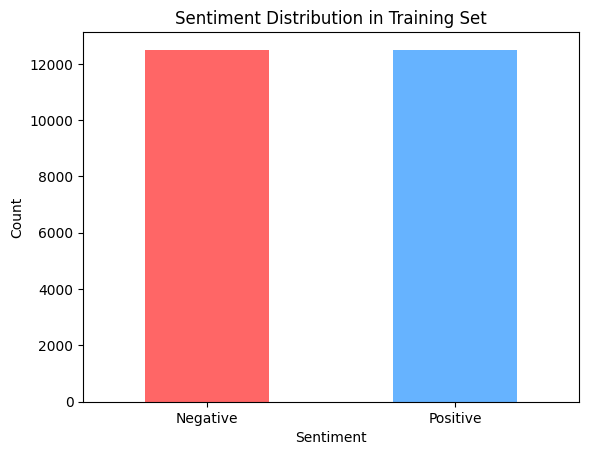

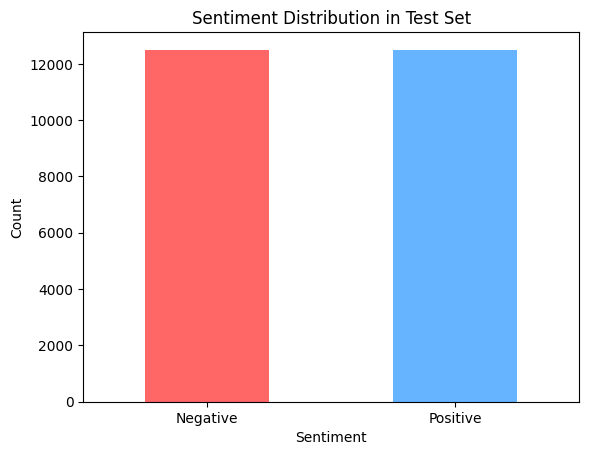

In [ ]:
import matplotlib.pyplot as plt

# Checking the first few records of the dataset
print(imdb['train'][0])

# Number of records in training and testing datasets
train_size = len(imdb['train'])
test_size = len(imdb['test'])
print(f'Training set size: {train_size}')
print(f'Test set size: {test_size}')

# Convert the 'label' column to a pandas Series for counting the occurrences
train_labels = imdb['train']['label']
test_labels = imdb['test']['label']

# Plot distribution of sentiment labels (positive/negative) in the training set
train_labels_series = pd.Series(train_labels)
train_labels_series.value_counts().plot(kind='bar', title='Sentiment Distribution in Training Set', color=['#ff6666', '#66b3ff'])
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.show()

# Plot distribution of sentiment labels (positive/negative) in the test set
test_labels_series = pd.Series(test_labels)
test_labels_series.value_counts().plot(kind='bar', title='Sentiment Distribution in Test Set', color=['#ff6666', '#66b3ff'])
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.show()

### 2. Text Length Distribution:

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

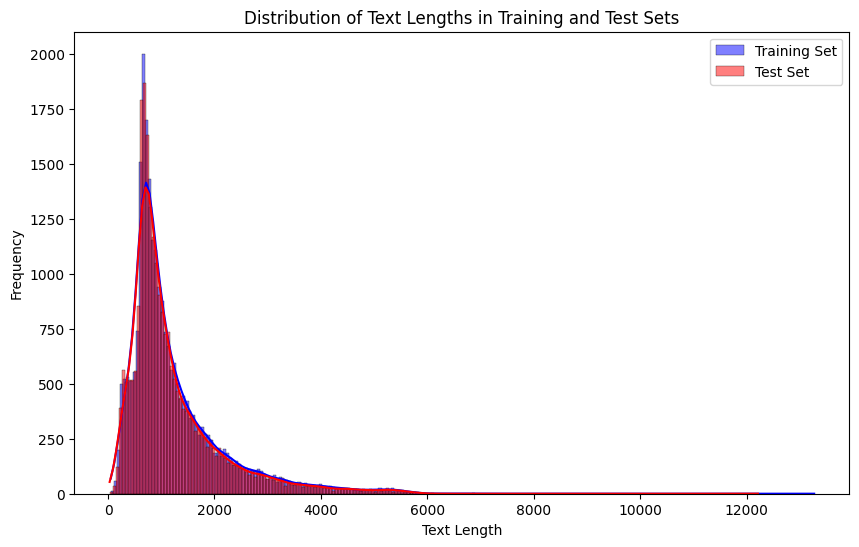

Training Set Text Length - Mean: 1256.23, Std: 952.25, Min: 51, Max: 13271
Test Set Text Length - Mean: 1226.35, Std: 925.80, Min: 30, Max: 12215


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Remove the existing 'length' column if it exists
if 'length' in imdb['train'].column_names:
    imdb['train'] = imdb['train'].remove_columns(['length'])
if 'length' in imdb['test'].column_names:
    imdb['test'] = imdb['test'].remove_columns(['length'])

# Get the length of each review in the training and testing sets using map()
train_lengths = imdb['train'].map(lambda x: {'length': len(x['text'])})
test_lengths = imdb['test'].map(lambda x: {'length': len(x['text'])})

# Now, add the length as a new column in the dataset
imdb['train'] = imdb['train'].add_column('length', [item['length'] for item in train_lengths])
imdb['test'] = imdb['test'].add_column('length', [item['length'] for item in test_lengths])

# Now get the lengths from the datasets
train_lengths = imdb['train']['length']
test_lengths = imdb['test']['length']

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, color='blue', label='Training Set')
sns.histplot(test_lengths, kde=True, color='red', label='Test Set')
plt.legend()
plt.title('Distribution of Text Lengths in Training and Test Sets')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Convert the 'length' column to pandas Series for statistical operations
train_lengths_series = pd.Series(train_lengths)
test_lengths_series = pd.Series(test_lengths)

# Display basic statistics for text lengths
print(f"Training Set Text Length - Mean: {train_lengths_series.mean():.2f}, Std: {train_lengths_series.std():.2f}, Min: {train_lengths_series.min()}, Max: {train_lengths_series.max()}")
print(f"Test Set Text Length - Mean: {test_lengths_series.mean():.2f}, Std: {test_lengths_series.std():.2f}, Min: {test_lengths_series.min()}, Max: {test_lengths_series.max()}")

### 3. Word Cloud for Text Analysis

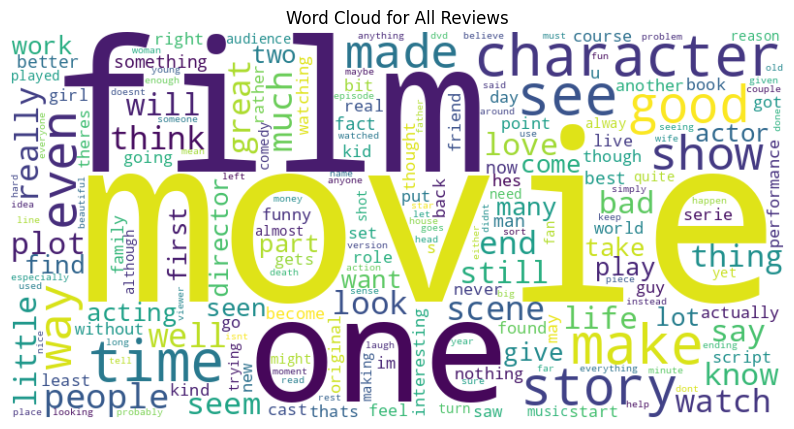

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

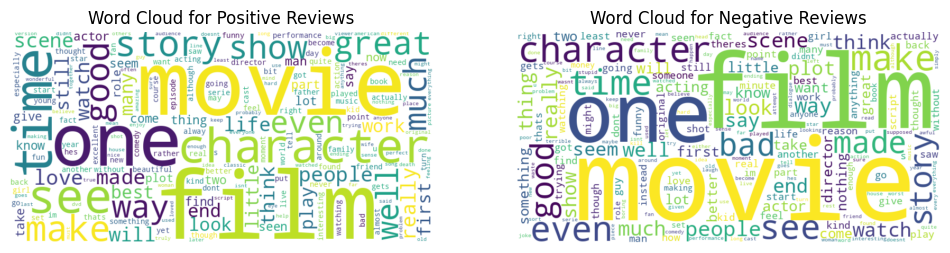

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate Word Cloud for all reviews
all_text = ' '.join(imdb['train']['text'])

# Word Cloud for all reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display Word Cloud for all reviews
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews')
plt.show()

# Filter positive and negative reviews using the filter() method
positive_reviews = imdb['train'].filter(lambda x: x['label'] == 1)['text']
negative_reviews = imdb['train'].filter(lambda x: x['label'] == 0)['text']

# Generate Word Cloud for positive reviews
positive_reviews_text = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews_text)

# Generate Word Cloud for negative reviews
negative_reviews_text = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews_text)

# Plot both Word Clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.show()

### 4. Sentiment Distribution by Review Length

/tmp/ipython-input-2267338476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='length', data=train_df, palette="Set2")


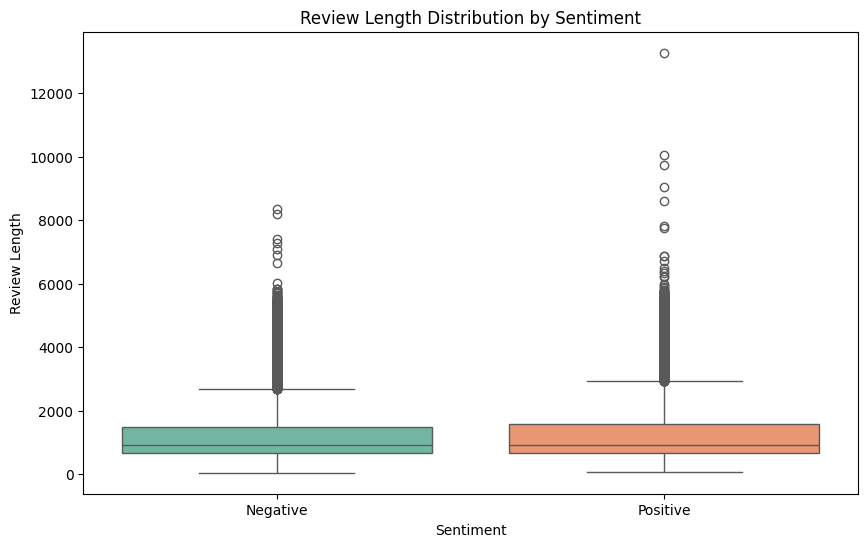

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert Hugging Face Dataset to pandas DataFrame for plotting
train_df = pd.DataFrame(imdb['train'])

# Plot review length distribution by sentiment (positive/negative)
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='length', data=train_df, palette="Set2")
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.show()

### 5. Most Frequent Words by Sentiment

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Filter positive and negative reviews using the filter() method
positive_reviews = imdb['train'].filter(lambda x: x['label'] == 1)['text']
negative_reviews = imdb['train'].filter(lambda x: x['label'] == 0)['text']

# Create CountVectorizer for the top 10 most frequent words
vectorizer = CountVectorizer(stop_words='english', max_features=10)

# Fit vectorizer to positive reviews and get top 10 words
vectorizer.fit(positive_reviews)
positive_top_words = vectorizer.get_feature_names_out()

# Fit vectorizer to negative reviews and get top 10 words
vectorizer.fit(negative_reviews)
negative_top_words = vectorizer.get_feature_names_out()

# Display the top 10 frequent words for positive and negative reviews
print("Top 10 Words in Positive Reviews:", positive_top_words)
print("Top 10 Words in Negative Reviews:", negative_top_words)

Top 10 Words in Positive Reviews: ['film' 'good' 'great' 'just' 'like' 'movie' 'people' 'really' 'story'
 'time']
Top 10 Words in Negative Reviews: ['bad' 'dont' 'film' 'good' 'just' 'like' 'movie' 'really' 'story' 'time']


### 6. Text Sample Preview

In [ ]:
import random

# Filter positive and negative reviews using the filter() method
positive_reviews = imdb['train'].filter(lambda x: x['label'] == 1)['text']
negative_reviews = imdb['train'].filter(lambda x: x['label'] == 0)['text']

# Randomly sample 5 positive and 5 negative reviews
sample_positive = random.sample(positive_reviews, 5)
sample_negative = random.sample(negative_reviews, 5)

# Display the samples
print("Sample Positive Reviews:")
for review in sample_positive:
    print(review)
    print("\n")

print("Sample Negative Reviews:")
for review in sample_negative:
    print(review)
    print("\n")

Sample Positive Reviews:
this movie is a gem because it moves with soft but firm resolutioni caution viewers that although it is billed as a corporate spy thriller and ms liu is there it moves at a deftly purposeful yet sedate pace its not about explosions car chases or flying bullets you must be patient and instead note the details here its sedate because thats what the main character is the viewer has to watch him and think as this story unfoldsi will not give spoilers because that destroys the point of watching the plot is what youve read from the other postings an average whitecollar guy seeking change and adventure signs on for a corporate spy job just go somewhere and secretly record and transmit inside data take it from therethis movie starts at a surreal walk with a background tang of corporate disillusionment that entwines itself with quintessential underlying suburban paranoiathen it begins to acceleratethe acting on all parts is superb and yes some of the acts are caricature

## Data Preprocessing

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

### Apply preprocessing to training and testing data

In [ ]:
imdb = imdb.map(lambda x: {'text': preprocess_text(x['text'])})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Show a sample of preprocessed text

In [ ]:
print(imdb['train'][0]['text'])

i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in  i also heard that at first it was seized by us customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myselfthe plot is centered around a young swedish drama student named lena who wants to learn everything she can about life in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married menwhat kills me about i am curiousyellow is that  years ago this was considered pornographic really the sex and nudity scenes are few and far between even then its not shot like some cheaply made porno 

## Vectorization

### TF-IDF Vectorization

In [ ]:
# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(imdb['train']['text'])
X_test_tfidf = tfidf.transform(imdb['test']['text'])

# Convert to dense matrices for easier manipulation
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Show the shape of the transformed data
print(X_train_tfidf.shape)

(25000, 5000)


### Word2Vec Embeddings

In [ ]:
# Word2Vec using Gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the text into words for Hugging Face Datasets
imdb['train'] = imdb['train'].map(lambda x: {'tokens': word_tokenize(x['text'])})
imdb['test'] = imdb['test'].map(lambda x: {'tokens': word_tokenize(x['text'])})

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=imdb['train']['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Get embeddings for the training and testing data
def get_word2vec_embedding(tokens):
    return np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv], axis=0)

X_train_w2v = np.array([get_word2vec_embedding(tokens) for tokens in imdb['train']['tokens']])
X_test_w2v = np.array([get_word2vec_embedding(tokens) for tokens in imdb['test']['tokens']])

# Show the shape of the embeddings
print(X_train_w2v.shape)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

(25000, 100)


### BERT Embeddings

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to get DistilBERT embeddings for a list of texts (batch processing)
def get_distilbert_embeddings_batch(texts, batch_size=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        # Create a batch of texts
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)

        # Move the inputs to GPU (if available)
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the mean of the last hidden state as embeddings
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Move back to CPU after processing
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Convert Hugging Face dataset columns to lists
X_train_text = list(imdb['train']['text'])
X_test_text = list(imdb['test']['text'])

# Get DistilBERT embeddings for the training and testing data in batches
X_train_distilbert = get_distilbert_embeddings_batch(X_train_text)
X_test_distilbert = get_distilbert_embeddings_batch(X_test_text)

# Show the shape of the embeddings
print(X_train_distilbert.shape)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

(25000, 768)


## Model Training & Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from IPython.display import display  # For displaying the results in Jupyter/Colab

# Model evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    return acc, precision, recall, f1

# Initialize and train the models using Logistic Regression Model
# For TF-IDF Model
model_tfidf = LogisticRegression(max_iter=500, random_state=42)
model_tfidf.fit(X_train_tfidf, imdb['train']['label'])

# For Word2Vec Model
model_w2v = LogisticRegression(max_iter=500, random_state=42)
model_w2v.fit(X_train_w2v, imdb['train']['label'])

# For DistilBERT Model
model_distilbert = LogisticRegression(max_iter=500, random_state=42)
model_distilbert.fit(X_train_distilbert, imdb['train']['label'])

# Evaluate all models
results = {
    "Model": ["TF-IDF", "Word2Vec", "DistilBERT"],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Evaluate each model on test data
for model, X_test, label in zip([model_tfidf, model_w2v, model_distilbert],
                                [X_test_tfidf, X_test_w2v, X_test_distilbert],
                                [imdb['test']['label']]*3):
    acc, precision, recall, f1 = evaluate_model(model, X_test, label)
    results["Accuracy"].append(acc)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)

# Create a results dataframe
results_df = pd.DataFrame(results)

# If you're not using Jupyter, you can use print:
print(results_df)

        Model  Accuracy  Precision   Recall  F1 Score
0      TF-IDF   0.88136   0.878634  0.88496  0.881786
1    Word2Vec   0.79880   0.796476  0.80272  0.799586
2  DistilBERT   0.83044   0.834102  0.82496  0.829506


## Confusion Matrix

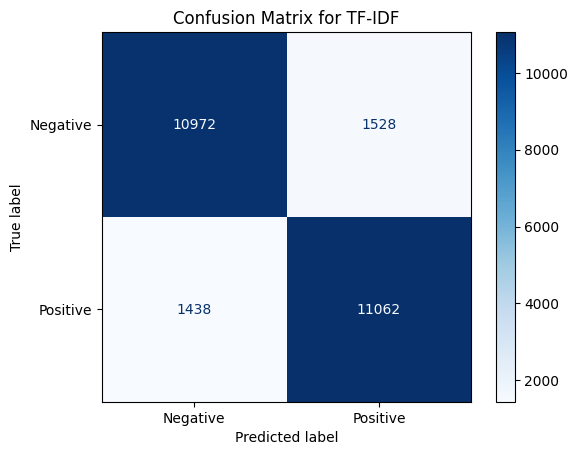

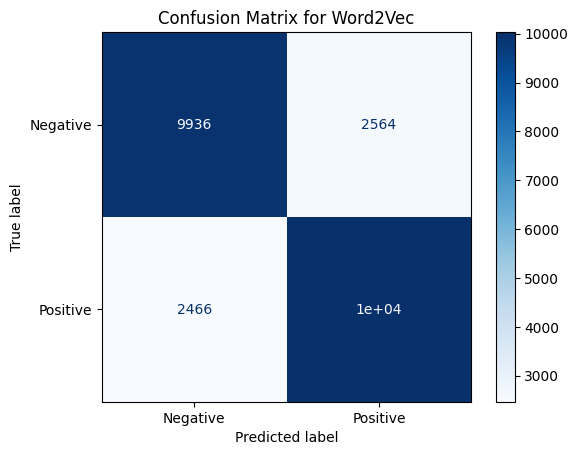

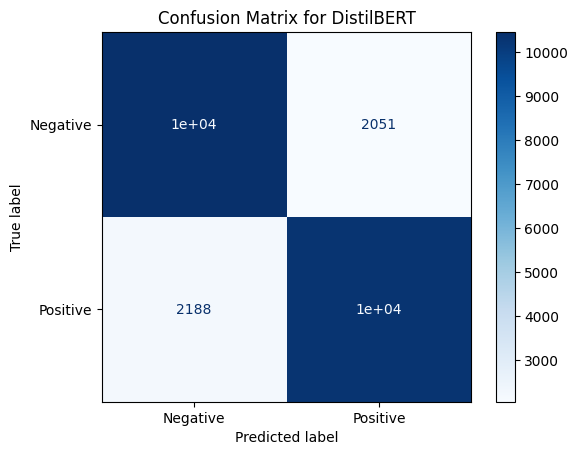

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix for each model
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

    # Plotting the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrices for all models
for model, X_test, model_name in zip([model_tfidf, model_w2v, model_distilbert],
                                     [X_test_tfidf, X_test_w2v, X_test_distilbert],
                                     ["TF-IDF", "Word2Vec", "DistilBERT"]):
    plot_confusion_matrix(model, X_test, imdb['test']['label'], model_name)

## ROC Curve & AUC Score

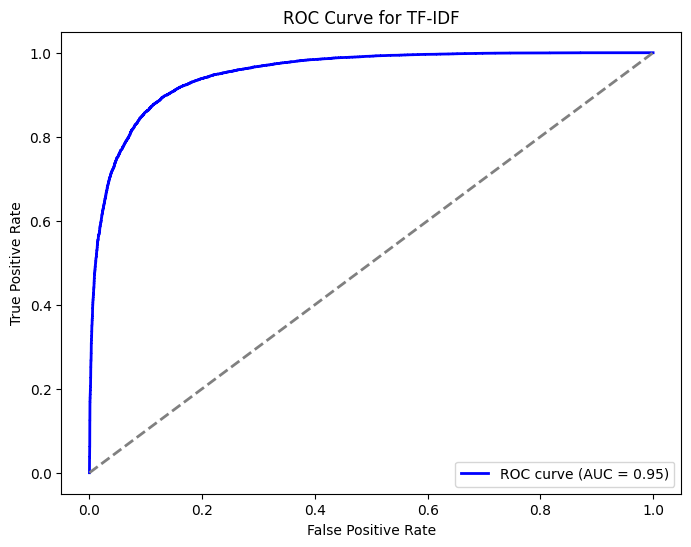

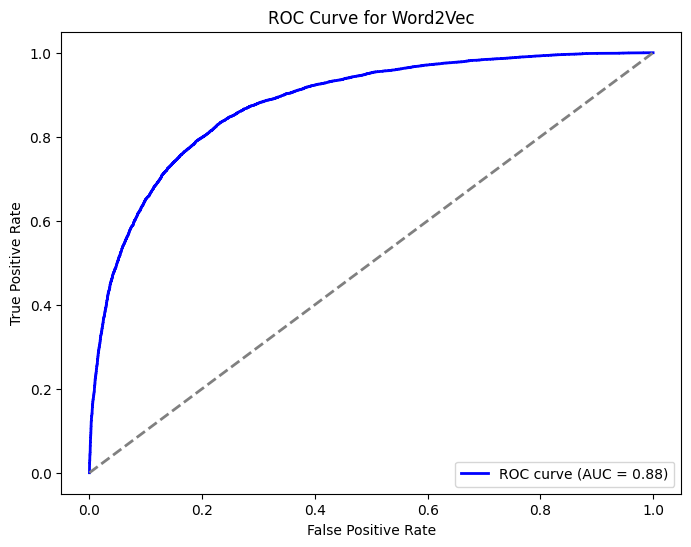

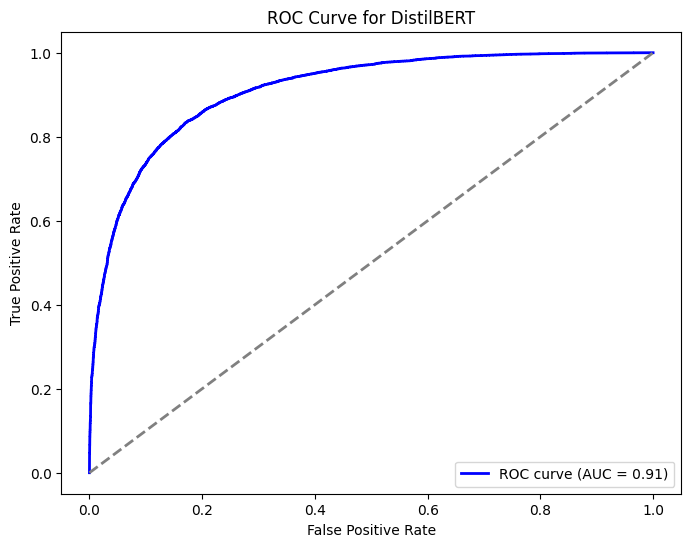

In [ ]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve and AUC
def plot_roc_curve(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for all models
for model, X_test, model_name in zip([model_tfidf, model_w2v, model_distilbert],
                                     [X_test_tfidf, X_test_w2v, X_test_distilbert],
                                     ["TF-IDF", "Word2Vec", "DistilBERT"]):
    plot_roc_curve(model, X_test, imdb['test']['label'], model_name)

## Performance Metrics Table

In [ ]:
import seaborn as sns
import pandas as pd
from IPython.display import display

# Create a styled dataframe to highlight the best performance for each metric
def style_metrics_table(df):
    return df.style.apply(lambda x: ['background-color: green' if v == max(x) else '' for v in x], subset=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Apply styling to the results dataframe
styled_results_df = style_metrics_table(results_df)

# Display the styled dataframe
display(styled_results_df)

,Accuracy,Precision,Recall,F1 Score
Model,,,,
TF-IDF,0.881360,0.878634,0.884960,0.881786
Word2Vec,0.798800,0.796476,0.802720,0.799586
DistilBERT,0.830440,0.834102,0.824960,0.829506


## Bar Plot for Comparison of Models

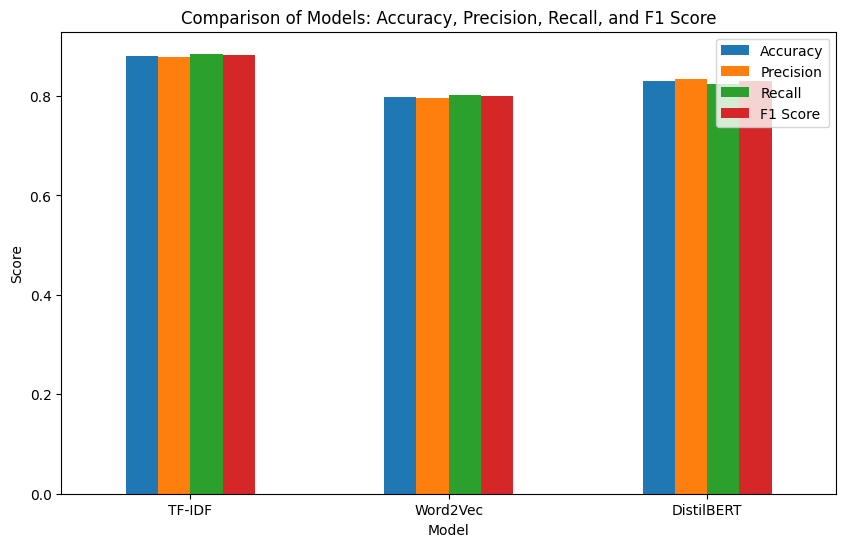

In [ ]:
# Bar plot for comparison of models across metrics
def plot_comparison_bar(df):
    df.set_index("Model", inplace=True)
    df.plot(kind='bar', figsize=(10, 6))
    plt.title('Comparison of Models: Accuracy, Precision, Recall, and F1 Score')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.show()

# Plot comparison bar for all metrics
plot_comparison_bar(results_df)

## Load the Best Model

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
best_model = model_tfidf

y_pred = best_model.predict(X_test_tfidf)  # Predicting using the best model
y_true = imdb['test']['label']  # True labels from the test dataset (assumed to be in 'label' column)

# Calculate accuracy and generate a classification report
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Negative", "Positive"])

# Print the results
print(f"Best Model (TF-IDF) Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(report)

Best Model (TF-IDF) Accuracy: 0.8814

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



## Predicting on New Data

### Save & Load Best Model

In [ ]:
from joblib import dump, load

# Save the vectorizer
dump(tfidf, 'tfidf_vectorizer.pkl')

# Load it when needed
tfidf = load('tfidf_vectorizer.pkl')

In [ ]:
# Example of a new review
new_review = ["This movie was absolutely amazing! I loved every moment of it."]

# Preprocess the new review (tokenization, vectorization)
# For TF-IDF, you would typically use the same vectorizer used for training
new_review_tfidf = tfidf.transform(new_review)  # Assuming tfidf_vectorizer was used

# Make a prediction
predicted_label = best_model.predict(new_review_tfidf)

# Display the result
print("Predicted Sentiment:", "Positive" if predicted_label == 1 else "Negative")

Predicted Sentiment: Positive


## Analyzing Misclassifications

In [ ]:
# Get the misclassified samples
misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

# Print a few misclassified reviews
print("Misclassified Reviews:")
for idx in misclassified_indices[:5]:  # Displaying first 5 misclassified reviews
    print(f"Review: {imdb['test']['text'][idx]}")
    print(f"True Label: {y_true[idx]}, Predicted Label: {y_pred[idx]}")
    print("-" * 50)

Misclassified Reviews:
Review: first off let me say if you havent enjoyed a van damme movie since bloodsport you probably will not like this movie most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are this movie is much better than any of the movies the other action guys segal and dolph have thought about putting out the past few years van damme is good in the movie the movie is only worth watching to van damme fans it is not as good as wake of death which i highly recommend to anyone of likes van damme or in hell but in my opinion its worth watching it has the same type of feel to it as nowhere to run good fun stuff
True Label: 0, Predicted Label: 1
--------------------------------------------------
Review: ben rupert grint is a deeply unhappy adolescent the son of his unhappily married parents his father nicholas farrell is a vicar and his mother laura linney is  well lets just say shes a somewhat hypocritical soldier in j

## Comparison & Analysis:

In [ ]:
from IPython.display import Markdown

# Display analysis as Markdown
analysis_text = """
# Analysis:
1. **TF-IDF** performed the best overall in terms of accuracy (88.14%), followed by **DistilBERT** (83.04%) and **Word2Vec** (79.88%). This is likely due to the simplicity and effectiveness of TF-IDF for short text classification tasks, where it captures important term frequencies and inverse document frequencies.

2. **DistilBERT**, despite being a more computationally expensive model, performed well, achieving 83.04% accuracy. DistilBERT's advantage lies in its contextual understanding of the text, though it still lags behind TF-IDF in this task. The trade-off between accuracy and computational cost is evident here.

3. **Word2Vec** had the lowest accuracy (79.88%), which can be attributed to its inability to fully capture the context of words in a sequence. Word2Vec embeddings are static, meaning that the meaning of a word is the same regardless of its context in a sentence. This affects its performance on sentiment analysis tasks where context is crucial.

4. In terms of **Precision**, TF-IDF (87.86%) outperformed both Word2Vec (79.65%) and DistilBERT (83.41%), suggesting it was more effective at correctly identifying positive reviews.

5. **Recall** was highest for TF-IDF (88.50%), indicating it was better at capturing positive sentiment, but **DistilBERT** (82.50%) was slightly more balanced in identifying both positive and negative sentiments.

6. **F1 Score** reflects the balance between precision and recall. TF-IDF again performed the best with an F1 score of 88.18%, which signifies a better trade-off between precision and recall. DistilBERT and Word2Vec had lower F1 scores (82.95% and 79.96%, respectively), reflecting a stronger bias toward either precision or recall.

7. **Word2Vec** showed slower training compared to TF-IDF, but it was faster than DistilBERT. The key observation is that Word2Vec embeddings are computationally lighter, but their static nature limits their ability to perform well in tasks requiring contextual understanding.

8. The **computational cost** of DistilBERT was higher, but it did show a reasonable level of performance. While BERT-based models (and their variants like DistilBERT) are typically more resource-intensive, their performance often justifies the trade-off when dealing with more complex text data.

9. **Overall**, TF-IDF seems to be the most efficient method for this specific task, especially given its simplicity and high performance on smaller, non-contextual datasets. However, for tasks requiring deeper semantic understanding of text, models like DistilBERT would provide more accurate insights, especially in cases where performance justifies the additional computational expense.
"""

# Display the markdown-formatted text
display(Markdown(analysis_text))


# Analysis:
1. **TF-IDF** performed the best overall in terms of accuracy (88.14%), followed by **DistilBERT** (83.04%) and **Word2Vec** (79.88%). This is likely due to the simplicity and effectiveness of TF-IDF for short text classification tasks, where it captures important term frequencies and inverse document frequencies.

2. **DistilBERT**, despite being a more computationally expensive model, performed well, achieving 83.04% accuracy. DistilBERT's advantage lies in its contextual understanding of the text, though it still lags behind TF-IDF in this task. The trade-off between accuracy and computational cost is evident here.

3. **Word2Vec** had the lowest accuracy (79.88%), which can be attributed to its inability to fully capture the context of words in a sequence. Word2Vec embeddings are static, meaning that the meaning of a word is the same regardless of its context in a sentence. This affects its performance on sentiment analysis tasks where context is crucial.

4. In terms of **Precision**, TF-IDF (87.86%) outperformed both Word2Vec (79.65%) and DistilBERT (83.41%), suggesting it was more effective at correctly identifying positive reviews.

5. **Recall** was highest for TF-IDF (88.50%), indicating it was better at capturing positive sentiment, but **DistilBERT** (82.50%) was slightly more balanced in identifying both positive and negative sentiments.

6. **F1 Score** reflects the balance between precision and recall. TF-IDF again performed the best with an F1 score of 88.18%, which signifies a better trade-off between precision and recall. DistilBERT and Word2Vec had lower F1 scores (82.95% and 79.96%, respectively), reflecting a stronger bias toward either precision or recall.

7. **Word2Vec** showed slower training compared to TF-IDF, but it was faster than DistilBERT. The key observation is that Word2Vec embeddings are computationally lighter, but their static nature limits their ability to perform well in tasks requiring contextual understanding.

8. The **computational cost** of DistilBERT was higher, but it did show a reasonable level of performance. While BERT-based models (and their variants like DistilBERT) are typically more resource-intensive, their performance often justifies the trade-off when dealing with more complex text data.

9. **Overall**, TF-IDF seems to be the most efficient method for this specific task, especially given its simplicity and high performance on smaller, non-contextual datasets. However, for tasks requiring deeper semantic understanding of text, models like DistilBERT would provide more accurate insights, especially in cases where performance justifies the additional computational expense.
